# pix2pix: Image-to-image translation with a conditional GAN

In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

# Connect my gdrive for saving checkpoints

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive

 Assignment_OramaVR.gdoc  'Colab Notebooks'   GitHub_recovery


In [ ]:
gdr_path = F"/content/gdrive/MyDrive/"
gdr_path

'/content/gdrive/MyDrive/'

## Load the dataset


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.7 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset, Image

# Download dataset from Hugging Face and explore it

In [ ]:
dataset = load_dataset("dream-textures/textures-color-normal-1k")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1426 [00:00<?, ? examples/s]

In [ ]:
dataset # only train set is available here.

DatasetDict({
    train: Dataset({
        features: ['color', 'normal'],
        num_rows: 1426
    })
})

In [ ]:
dataset.shape

{'train': (1426, 2)}

In [ ]:
dataset['train'].shape[0]

In [ ]:
dataset.column_names

In [ ]:
dataset.cache_files

In [ ]:
# visualize the 11-th image and its corresponding normal map
plt.figure()
plt.imshow(dataset["train"][10]['color'])  # NOTE. Already decoded jpeg, NO need to call tf.io.decode_jpeg()
plt.figure()
plt.imshow(dataset["train"][10]['normal'])

In [ ]:
sample_image = dataset["train"][0]['color']
plt.imshow(sample_image)
print('range of pixel values: from', tf.reduce_min(sample_image).numpy(), ' to ', tf.reduce_max(sample_image).numpy())


In [ ]:
sample_image = dataset["train"][0]['normal']
plt.imshow(sample_image)
print('range of pixel values: from', tf.reduce_min(sample_image).numpy(), ' to ', tf.reduce_max(sample_image).numpy())


In [ ]:
type(sample_image)

In [ ]:
# Convert the PIL image to Tensor
img_to_tensor = tf.convert_to_tensor(sample_image)
# print the converted Torch tensor
print(img_to_tensor)

### define a function that loads the color and normal map, converts to tensor and returns the float casted tensors


In [ ]:
# image_name is a dictionary of two keys and 1 item per key
def load(image_name):
  image_color = image_name['color']
  image_normal = image_name['normal']

  color_tens = tf.convert_to_tensor(image_color)
  normal_tens = tf.convert_to_tensor(image_normal)

  color_tens = tf.cast(color_tens, tf.float32)
  normal_tens = tf.cast(normal_tens, tf.float32)

  return color_tens, normal_tens

In [ ]:
inp, re = load(dataset["train"][11])
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

# plot WITHOUT normalization with 255..
# CHECK if it is actually needed in *load()*

In [ ]:
plt.figure()
plt.imshow(dataset["train"][11]['color'])
plt.figure()
plt.imshow(dataset["train"][11]['normal'])

# Data Pre-processing

## DISCARD corrupt image at 465!

In [ ]:
# https://discuss.huggingface.co/t/remove-a-row-specific-index-from-the-dataset/12875/5
exclude_idx = [465]

dataset_new = dataset['train'].select(
    (
        i for i in range(len(dataset['train']))
        if i not in set(exclude_idx)
    )
)

Parameter 'indices'=<generator object <genexpr> at 0x7b2fe5813ed0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [ ]:
dataset_new

Dataset({
    features: ['color', 'normal'],
    num_rows: 1425
})

In [ ]:
# attempt to put this train part back...
dataset['train'] = dataset_new
dataset

DatasetDict({
    train: Dataset({
        features: ['color', 'normal'],
        num_rows: 1425
    })
})

### [OPTIONAL] Verify that the range of values is in [0, 255] for color *images*

# WARNING: fills up the GPU memory by 2GB!

In [ ]:
conc_tens = tf.convert_to_tensor(dataset["train"][0]['color'])

for i, im in enumerate(dataset["train"]):
  # print('i=', i)

  im_tens = tf.convert_to_tensor(im['color'])

  # print(im_tens)

  # rank of image 35 is [2] --> tensor [512, 512] NOT [512, 512, 3]
  if tf.rank(im_tens).numpy() != 3:
    print('skipping image:', i)
    continue

  conc_tens = tf.concat([conc_tens, im_tens], axis=0)

  # manually stop at 464 because enumerating on item 465 gives an error!
  # if i == 464:
  #   break

print('Concatenated tensor shape: ', conc_tens.shape)

In [ ]:
# kept images
kept_N = int(conc_tens.shape[0] / 512) - 1 # because image 0 is added twice
kept_N

In [ ]:
# find min/max
print('value range: ', tf.reduce_min(conc_tens).numpy(), ' to ', tf.reduce_max(conc_tens).numpy())

In [ ]:
conc_tens.shape

In [ ]:
# image 35 has wrong dimensions
dataset["train"][35]['color']
tf.convert_to_tensor(dataset["train"][35]['color'])
tf.rank(tf.convert_to_tensor(dataset["train"][35]['color'])).numpy()

### [OPTIONAL] Verify that the range of values is in [0, 255] for *normal map* images

In [ ]:
conc_tens = tf.convert_to_tensor(dataset["train"][0]['normal'])

for i, im in enumerate(dataset["train"]):
  # print('i=', i)

  im_tens = tf.convert_to_tensor(im['normal'])

  # print(im_tens)
  # break

  # rank of image 35 is [2] --> tensor [512, 512] NOT [512, 512, 3]
  if tf.rank(im_tens).numpy() != 3:
    print('skipping image:', i)
    continue

  conc_tens = tf.concat([conc_tens, im_tens], axis=0)

  # manually stop at 464 because item 465 gives an error
  # if i == 464:
  #   break

print('Concatenated tensor shape: ', conc_tens.shape)

In [ ]:
conc_tens = tf.convert_to_tensor(dataset["train"][0]['normal'])

## helper functions

In [ ]:
# NOTE. When some *color* images were skipped in the previous loop, here there is no issue...
# Normalizing the images to [-1, 1]
def normalize(color_image, normal_map_image):
  color_image = (color_image / 127.5) - 1
  normal_map_image = (normal_map_image / 127.5) - 1

  return color_image, normal_map_image

In [ ]:
# image_file is a dictionary of two keys and 1 item per key
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  # input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

# Re-formulate list of image **pairs** in tensor form and create the tf.data.Dataset properly




In [ ]:
list_im_pairs_ALL = []

# with tf.device("CPU"):

for i, im in enumerate(dataset["train"]):
  # print('i=', i)
  color_im_tens = tf.convert_to_tensor(im['color'])
  normal_im_tens = tf.convert_to_tensor(im['normal'])

  # rank of image 35 is [2] --> tensor [512, 512] NOT [512, 512, 3]
  if tf.rank(tf.squeeze(color_im_tens)).numpy() != 3:
    print('skipping image:', i)
    continue

  # --- STOP LOADING at 1000 images due to RAM overflow -----
  if i == 800: #1000:
    print('stopped loading images')
    break

  list_im_pairs_ALL.append([color_im_tens, normal_im_tens])

skipping image: 35
skipping image: 155
skipping image: 300
skipping image: 366
skipping image: 494
skipping image: 712
skipping image: 727
skipping image: 733
skipping image: 790
stopped loading images


In [ ]:
len(list_im_pairs_ALL)

791

# CHECK BUFFER_SIZE!

In [ ]:
BUFFER_SIZE = 200 # 461
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 512x512 in size
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [ ]:
# TO DO: shuffle dataset

In [ ]:
# SPLIT images (roughly 80%-20% split)
N_train = int(0.8 * len(list_im_pairs_ALL))
N_train

632

In [ ]:
# dataset_tmp = tf.data.Dataset.from_tensor_slices(list_im_pairs_ALL[:1200]) # every element is a list of 2 tensors
dataset_tmp = tf.data.Dataset.from_tensor_slices(list_im_pairs_ALL[:N_train])

dataset_tmp

<_TensorSliceDataset element_spec=TensorSpec(shape=(2, 512, 512, 3), dtype=tf.uint8, name=None)>

In [ ]:
# verify it is looking alright

# for j, i in enumerate(dataset_tmp):
#   print(len(i))
#   # print(i.numpy())
#   print(i)
#   print('=======================')

#   if j == 10:
#     break

# RE-WRITE load to accept a list of 2 tensors, not dataset dictionary

In [ ]:
# image_name is a LIST of two tensors (dtype=uint8)
def load(image_name):
  color_tens = image_name[0] # image_name['color']
  normal_tens = image_name[1] # image_name['normal']

  # color_tens = tf.convert_to_tensor(image_color) # already a tensor...
  # normal_tens = tf.convert_to_tensor(image_normal)

  color_tens = tf.cast(color_tens, tf.float32)
  normal_tens = tf.cast(normal_tens, tf.float32)

  return color_tens, normal_tens

# Normalizing the images to [-1, 1]
def normalize(color_image, normal_map_image):
  color_image = (color_image / 127.5) - 1
  normal_map_image = (normal_map_image / 127.5) - 1

  return color_image, normal_map_image

In [ ]:
# image_file is a dictionary of two keys and 1 item per key
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  # input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
# # test them
# for i in dataset_tmp:
#   im_1, im_2 = load_image_train(i)
#   break

In [ ]:

train_dataset = dataset_tmp.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# same for test set

In [ ]:
# dataset_TEST = tf.data.Dataset.from_tensor_slices(list_im_pairs_ALL_test) # every element is a list of 2 tensors
dataset_TEST = tf.data.Dataset.from_tensor_slices(list_im_pairs_ALL[N_train:])
dataset_TEST

<_TensorSliceDataset element_spec=TensorSpec(shape=(2, 512, 512, 3), dtype=tf.uint8, name=None)>

In [ ]:
# use the same load_image_train as I don't do any jittering in the train image anyway...
test_dataset = dataset_TEST.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
test_dataset = test_dataset.shuffle(BUFFER_SIZE) # <-- check if this needs to be smaller!
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None))>

In [ ]:
# list_im_pairs_ALL = [] # <-- in case the garbage collector saves ram

## Build the generator

The generator of your pix2pix cGAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597){:.external}. A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the [Image segmentation](../images/segmentation.ipynb) tutorial and on the [U-Net project website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/){:.external}.)

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

Define the downsampler (encoder):

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
# down_model = downsample(3, 4)
# down_result = down_model(tf.expand_dims(inp, 0))
# print (down_result.shape)

Define the upsampler (decoder):

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
# up_model = upsample(3, 4)
# up_result = up_model(down_result)
# print (up_result.shape)

Define the generator with the downsampler and the upsampler:

In [ ]:
def Generator():
  # inputs = tf.keras.layers.Input(shape=[256, 256, 3]) MINE.
  inputs = tf.keras.layers.Input(shape=[512, 512, 3])

  # down_stack = [
  #   downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
  #   downsample(128, 4),  # (batch_size, 64, 64, 128)
  #   downsample(256, 4),  # (batch_size, 32, 32, 256)
  #   downsample(512, 4),  # (batch_size, 16, 16, 512)
  #   downsample(512, 4),  # (batch_size, 8, 8, 512)
  #   downsample(512, 4),  # (batch_size, 4, 4, 512)
  #   downsample(512, 4),  # (batch_size, 2, 2, 512)
  #   downsample(512, 4),  # (batch_size, 1, 1, 512)
  # ]

  # strides = 2 -> sizes are different when input dim is 512x512
  # ------------------------------------------------------------
  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 256, 256, 64)
    downsample(128, 4),  # (batch_size, 128, 128, 128)
    downsample(256, 4),  # (batch_size, 64, 64, 256)
    downsample(512, 4),  # (batch_size, 32, 32, 512)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512) <-- ADDED THIS!!
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  # up_stack = [
  #   upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
  #   upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
  #   upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
  #   upsample(512, 4),  # (batch_size, 16, 16, 1024)
  #   upsample(256, 4),  # (batch_size, 32, 32, 512)
  #   upsample(128, 4),  # (batch_size, 64, 64, 256)
  #   upsample(64, 4),  # (batch_size, 128, 128, 128)
  # ]
  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(512, 4),  # (batch_size, 32, 32, 1024) <-- ADDED THIS!
    upsample(256, 4),  # (batch_size, 64, 64, 512)
    upsample(128, 4),  # (batch_size, 128, 128, 256)
    upsample(64, 4),  # (batch_size, 256, 256, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

In [ ]:
generator = Generator()


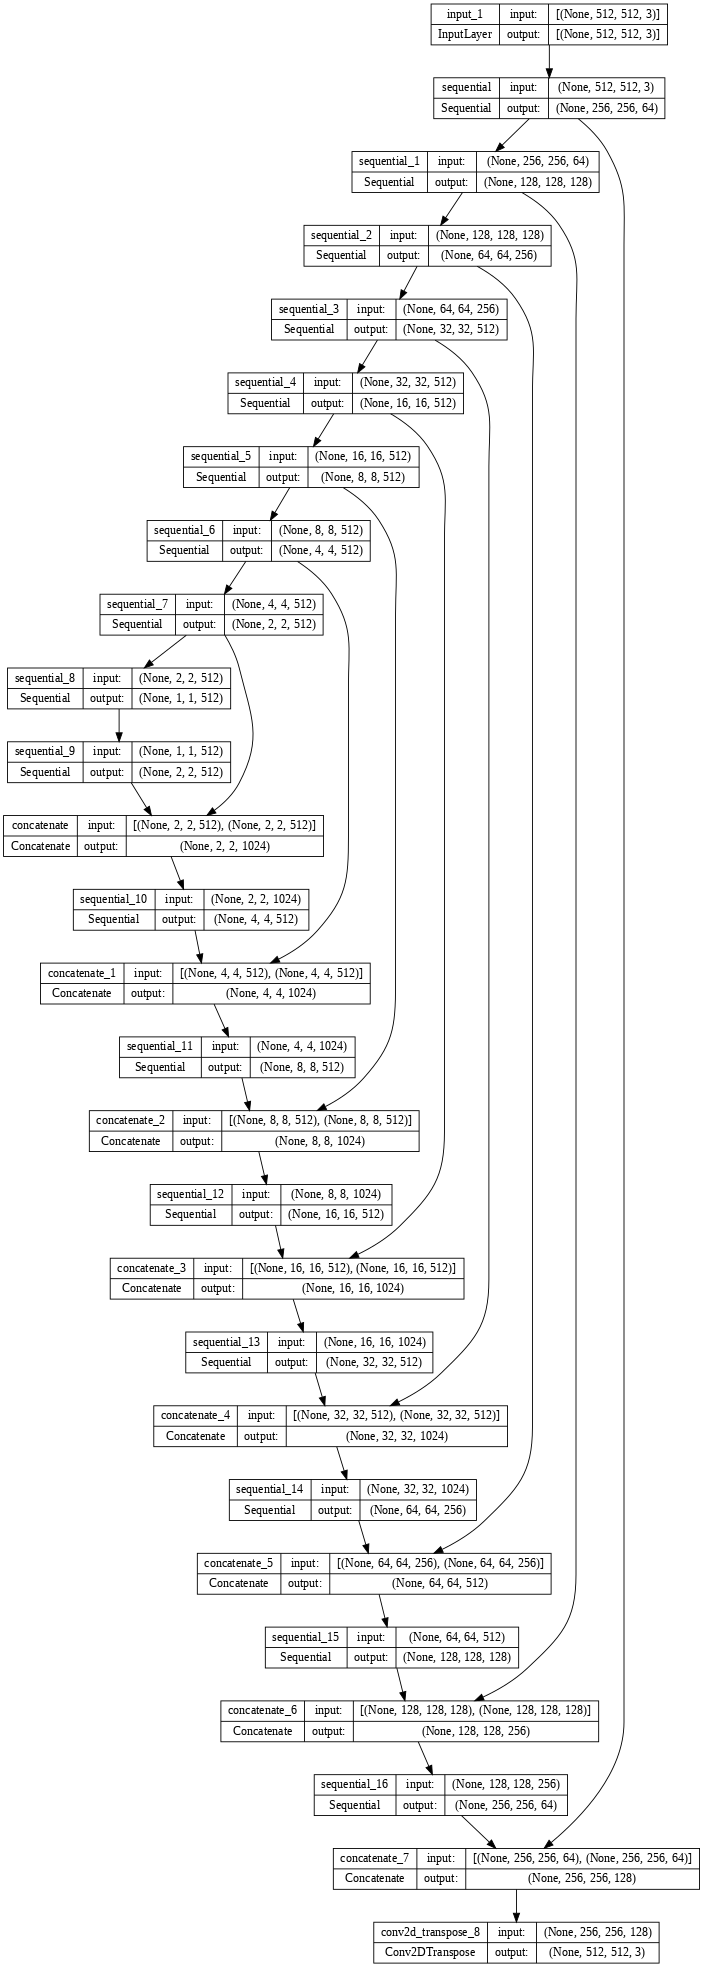

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator:

# WARNING, running this takes-up 10GB in GPU

In [ ]:
# gen_output = generator(inp[tf.newaxis, ...], training=False)
# plt.imshow(gen_output[0, ...])

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to **classify if each image _patch_ is real or not real**, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs:
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

Let's define the discriminator:

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  # inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  # tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
  inp = tf.keras.layers.Input(shape=[512, 512, 3], name='input_image')  # MINE. modified dimensions
  tar = tf.keras.layers.Input(shape=[512, 512, 3], name='target_image')

  # x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  # down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  # down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  # down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 512, 512, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 256, 256, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 128, 128, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 64, 64, 256)


  # zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 64+2, 64+2, 256)

  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512) --> in my case (bs, 66-3, 66-3, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512) --> in my case (bs, 63+2, 63+2, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1) --> in my case (bs, 65-3, 65-3, 512)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

In [ ]:
discriminator = Discriminator()


In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

In [ ]:
# disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
# plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
# plt.colorbar()

### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the optimizers and a checkpoint-saver


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
# checkpoint_dir = './training_checkpoints_1200_IMAGES'
checkpoint_dir = '/content/gdrive/MyDrive/training_checkpoints_1200_IMAGES'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

Note: The `training=True` is intentional here since you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Test the function:

# NOTE this takes up 10GB in GPU!!!!

In [ ]:
# for example_input, example_target in test_dataset.take(1):
#   generate_images(generator, example_input, example_target)

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [ ]:
# log_dir="logs_1200_IMAGES/"
log_dir = "/content/gdrive/MyDrive/logs_1200_IMAGES/"
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//500)# step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//500)# step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//500)# step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//500)# step=step//1000)

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 500 == 0: # 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        # print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
        print(f'Time taken for 500 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step}") # {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

Launch the TensorBoard viewer (Sorry, this doesn't
display on tensorflow.org):

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

# OR

In [ ]:
# !kill 15925

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir {log_dir}

TRAIN LOOP

Time taken for 500 steps: 145.90 sec



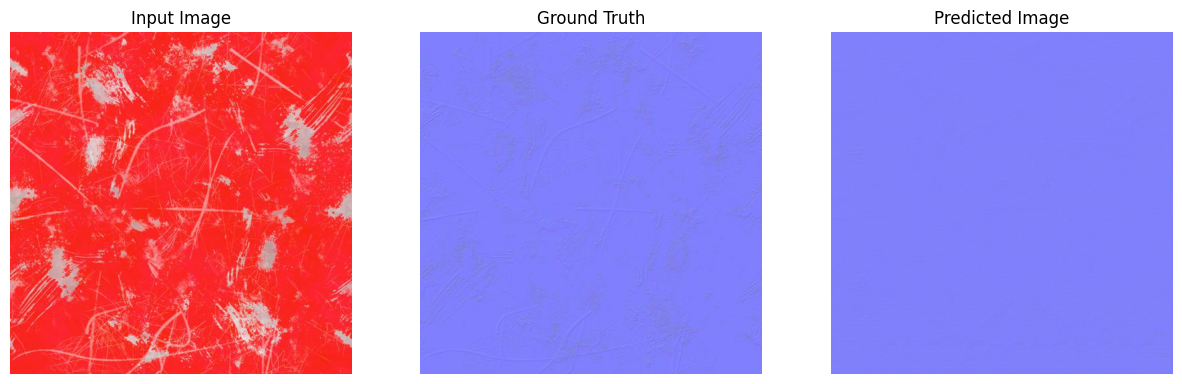

Step: 80k


In [ ]:
fit(train_dataset, test_dataset, steps=40001) # , steps=20000) # , steps=10000) # steps=40000)

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## DOWNLOAD CHECKPOINTS (otherwise they get erased when session is terminated)

In [ ]:
from google.colab import files

In [ ]:
files.download('./training_checkpoints_1200_IMAGES/checkpoint')  # ({checkpoint_dir}/*)

In [ ]:
files.download('./training_checkpoints_1200_IMAGES/ckpt-1.data-00000-of-00001')

In [ ]:
files.download('./training_checkpoints_1200_IMAGES/ckpt-4.data-00000-of-00001')

In [ ]:
files.download('./training_checkpoints_1200_IMAGES/ckpt-4.index')

In [ ]:
!ls -lah training_checkpoints_1200_IMAGES

In [ ]:
!ls -lah

# SAVE TO DRIVE

In [ ]:
# from google.colab import drive

In [ ]:
# drive.mount('/content/gdrive')

In [ ]:
# !ls /content/gdrive/My Drive

In [ ]:
# path = F"/content/gdrive/My Drive/"

In [ ]:
# ?
# !cp ./training_checkpoints_1200_IMAGES/checkpoint /content/gdrive/My Drive

# CLEAR session.

In [ ]:
tf.keras.backend.clear_session()

## Restore the latest checkpoint and test the network

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

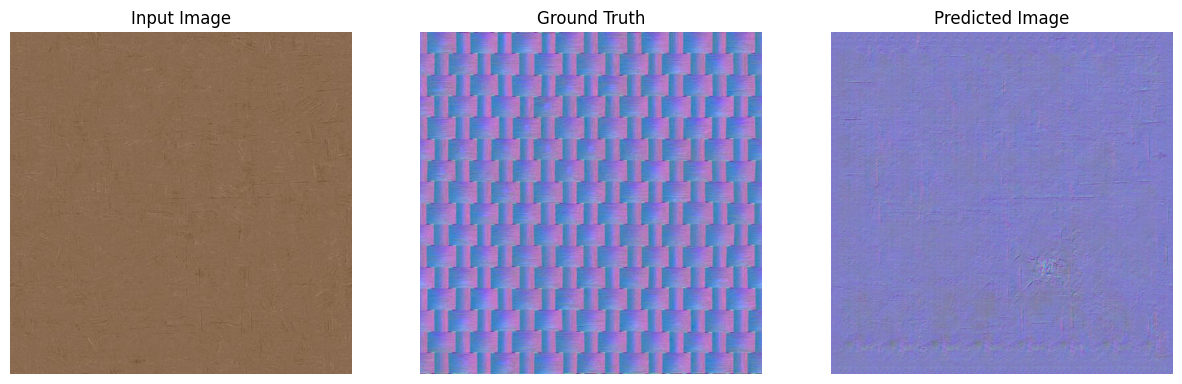

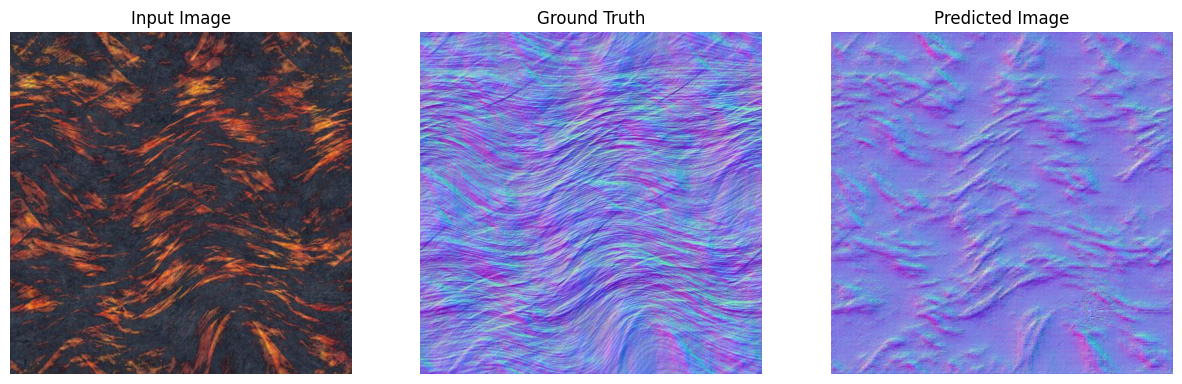

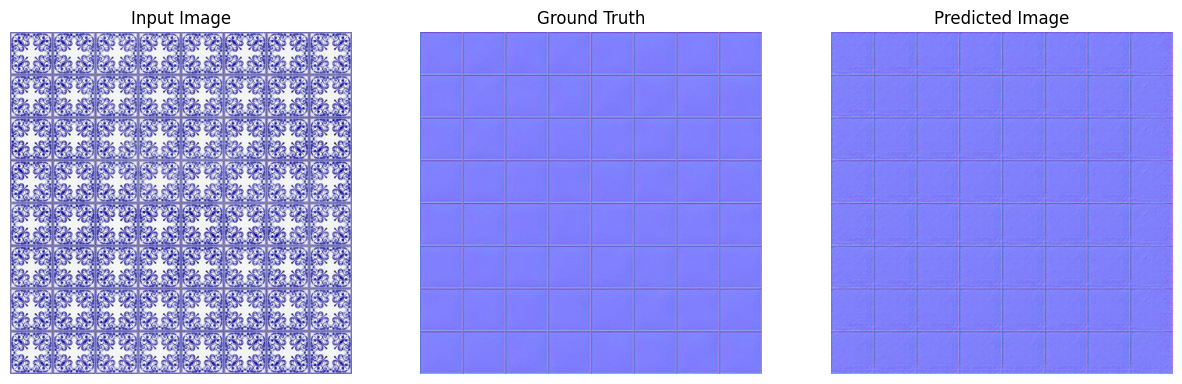

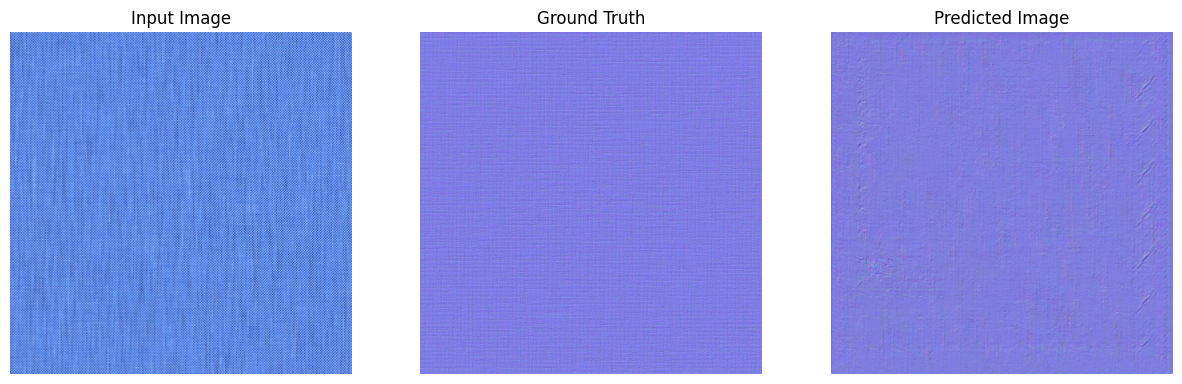

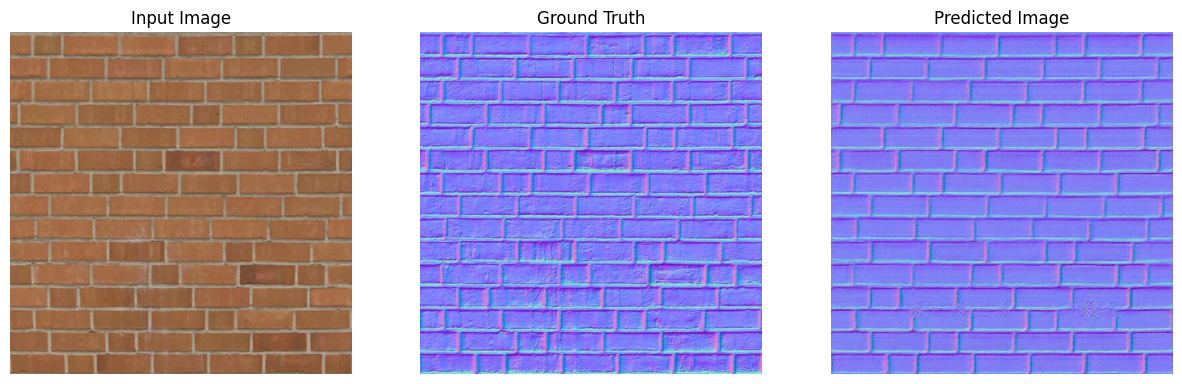

In [ ]:
# Run the trained model on a few examples from the TRAIN set
for inp, tar in train_dataset.take(5):
  generate_images(generator, inp, tar)

# Count model parameters

In [ ]:
from keras.utils.layer_utils import count_params


In [ ]:
print('Generator number of parameters: ', count_params(generator.trainable_weights))

In [ ]:
print('Discriminator number of parameters: ', count_params(discriminator.trainable_weights))

In [ ]:
pwd

In [ ]:
ls

In [ ]:
ls -lah training_checkpoints/

# Continue training from loaded checkpoint


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
!kill 2476

In [ ]:
fit(train_dataset, test_dataset, steps=20001)

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [ ]:
!ls -lah {checkpoint_dir}

In [ ]:
from google.colab import files

In [ ]:
files.download('./training_checkpoints_1200_IMAGES/ckpt-8.index')

In [ ]:
files.download('./training_checkpoints_1200_IMAGES/ckpt-8.data-00000-of-00001')

In [ ]:
!ls -lah {log_dir}/fit/20230809-085742

In [ ]:
files.download('./logs_1200_IMAGES/fit/20230809-085742/events.out.tfevents.1691571462.1ce24c3430f9.792.0.v2')

In [ ]:
files.download('./logs_1200_IMAGES/fit/20230809-105709/events.out.tfevents.1691578629.1ce24c3430f9.33119.0.v2')

# CONTINUE for another 20K steps

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
ls -lah {checkpoint_dir}

In [ ]:
# upload files first
from google.colab import files

In [ ]:
!ls -lah training_checkpoints_1200_IMAGES

In [ ]:
mkdir training_checkpoints_1200_IMAGES

In [ ]:
!ls training_checkpoints_1200_IMAGES

In [ ]:
# files.upload('Users/tasos/Downloads/ckpt-8.index')
f = files.upload()

In [ ]:
f = files.upload()

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
fit(train_dataset, test_dataset, steps=20001)